In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, GRU, Dropout, Flatten, Conv1D, BatchNormalization, Activation
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from tensorflow.keras import regularizers
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, LSTM, Reshape, Concatenate, TimeDistributed, Bidirectional
import os

# mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Model training parameters
n_epochs = 100
batch_size = 64
es_patience = 12
lr_patience = 6
min_lr = 1e-6
factor = 0.3

In [3]:
def build_hdnn_model(X_train):
    input_shape = (X_train.shape[1], X_train.shape[2])  # (time, features)
    inputs = Input(shape=input_shape)

    # CNN Path
    reshaped = Reshape((input_shape[1], input_shape[0], 1))(inputs) # (features, time)
    x_cnn = Conv2D(32, kernel_size=(3, 1), padding='same', kernel_regularizer=regularizers.l2(0.005))(reshaped)
    x_cnn = BatchNormalization()(x_cnn)
    x_cnn = Activation('tanh')(x_cnn)

    x_cnn = Conv2D(48, kernel_size=(5, 1), padding='same', kernel_regularizer=regularizers.l2(0.005))(x_cnn)
    x_cnn = BatchNormalization()(x_cnn)
    x_cnn = Activation('tanh')(x_cnn)

    x_cnn = MaxPooling2D(pool_size=(2, 1))(x_cnn)
    x_cnn = Flatten()(x_cnn)
    x_cnn = Dropout(0.3)(x_cnn)

    # BiLSTM Path
    x_lstm = Bidirectional(LSTM(64, return_sequences=True,kernel_regularizer=regularizers.l2(0.005)))(inputs)
    x_lstm = Bidirectional(LSTM(64,kernel_regularizer=regularizers.l2(0.005)))(x_lstm)
    x_lstm = Dropout(0.3)(x_lstm)

    # Merging Paths
    merged = Concatenate()([x_cnn, x_lstm])
    x = Dense(64, activation='tanh',kernel_regularizer=regularizers.l2(0.001))(merged)
    x = Dropout(0.3)(x)
    x = Dense(32, activation='tanh',kernel_regularizer=regularizers.l2(0.001))(x)

    output = Dense(1, activation='relu', name='rul')(x)

    model = Model(inputs=inputs, outputs=output)
    return model

def compile_and_train_hdnn(model, X_train, y_train, X_val, y_val, name="unknown"):
    # Compile model
    model.compile(
        optimizer=Adam(learning_rate=0.0003),
        loss='mse',
        metrics=[RootMeanSquaredError(name='rmse')]
    )

    # Callbacks
    es = EarlyStopping(monitor='val_loss', patience=es_patience, restore_best_weights=True)
    lr = ReduceLROnPlateau(monitor='val_loss', factor=factor, patience=lr_patience, min_lr=min_lr, verbose=1)

    # Train
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=n_epochs,
        batch_size=batch_size,
        callbacks=[es, lr],
        verbose=1
    )

    return history

# Metrics
def rmse(y_true, y_pred):
    return np.sqrt(np.mean(np.square(y_true - y_pred)))

def phm_score(y_true, y_pred):
    scores = []
    for true, pred in zip(y_true, y_pred):
        if pred > true:
            score = np.exp(np.abs(pred - true) / 13) - 1
        else:
            score = np.exp(np.abs(pred - true) / 10) - 1
        scores.append(score)
    return np.sum(scores)

# Testing and Evaluating Model
def evaluate_model(model, test_data, name="unknown"):
    X_test = test_data['X_test']
    y_test = test_data['y_test']

    y_pred = model.predict(X_test)
    y_pred = y_pred.flatten()

    rmse_score = rmse(y_test, y_pred)
    phm = phm_score(y_test, y_pred)

    return rmse_score, phm, y_test, y_pred

In [4]:
def pipeline(dataset_names, base_path):
    results = []
    histories = {}
    all_preds = {}

    for name in dataset_names:

        X = np.load(f'{base_path}/{name}_X_augmented.npy')
        y = np.load(f'{base_path}/{name}_y_augmented.npy')
        test_data = np.load(f'{base_path}/{name}_test_windows.npz')

        X_train, X_val, y_train, y_val = train_test_split(
            X, y,
            test_size=0.2,
            random_state=42,
            stratify=np.floor(y/10).astype(int)
        )

        print(f"[{name}] Train shape: {X_train.shape}, Val shape: {X_val.shape}")

        # Set all RUL values >= 130 to 130
        y_train[y_train >= 130] = 130

        model = build_hdnn_model(X_train=X_train)
        history = compile_and_train_hdnn(model, X_train, y_train, X_val, y_val, name=name)
        rmse_score, phm, y_test, y_pred = evaluate_model(model, test_data, name=name)

        # Save results
        results.append({'Dataset': name, 'RMSE': rmse_score, 'Score': phm})
        histories[name] = history
        all_preds[name] = (y_test, y_pred, rmse_score, phm)


        # Save model
        model.save(f'HDNN_{name}.keras')

    return results, histories, all_preds

In [5]:
# Dataset names
dataset_names = ["FD001", "FD002", "FD003", "FD004"]

# Set base path
base_path = '/content/drive/MyDrive/I_Learn_Deep/tensors'

results, histories, all_preds = pipeline(dataset_names, base_path)

[FD001] Train shape: (11475, 30, 15), Val shape: (2869, 30, 15)
Epoch 1/100
180/180 ━━━━━━━━━━━━━━━━━━━━ 14s 23ms/step - loss: 7036.9956 - rmse: 83.8731 - val_loss: 6692.4678 - val_rmse: 81.7992 - learning_rate: 3.0000e-04
Epoch 2/100
180/180 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - loss: 6669.7368 - rmse: 81.6588 - val_loss: 6423.0737 - val_rmse: 80.1387 - learning_rate: 3.0000e-04
Epoch 3/100
180/180 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - loss: 6317.0981 - rmse: 79.4730 - val_loss: 6176.0322 - val_rmse: 78.5836 - learning_rate: 3.0000e-04
Epoch 4/100
180/180 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 6130.7314 - rmse: 78.2921 - val_loss: 5942.1626 - val_rmse: 77.0819 - learning_rate: 3.0000e-04
Epoch 5/100
180/180 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - loss: 5881.0938 - rmse: 76.6831 - val_loss: 5716.2432 - val_rmse: 75.6026 - learning_rate: 3.0000e-04
Epoch 6/100
180/180 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - loss: 5578.9839 - rmse: 74.6870 - val_loss: 5498.8740 - val_rmse: 74.1512 - learning_rate

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 97ms/step


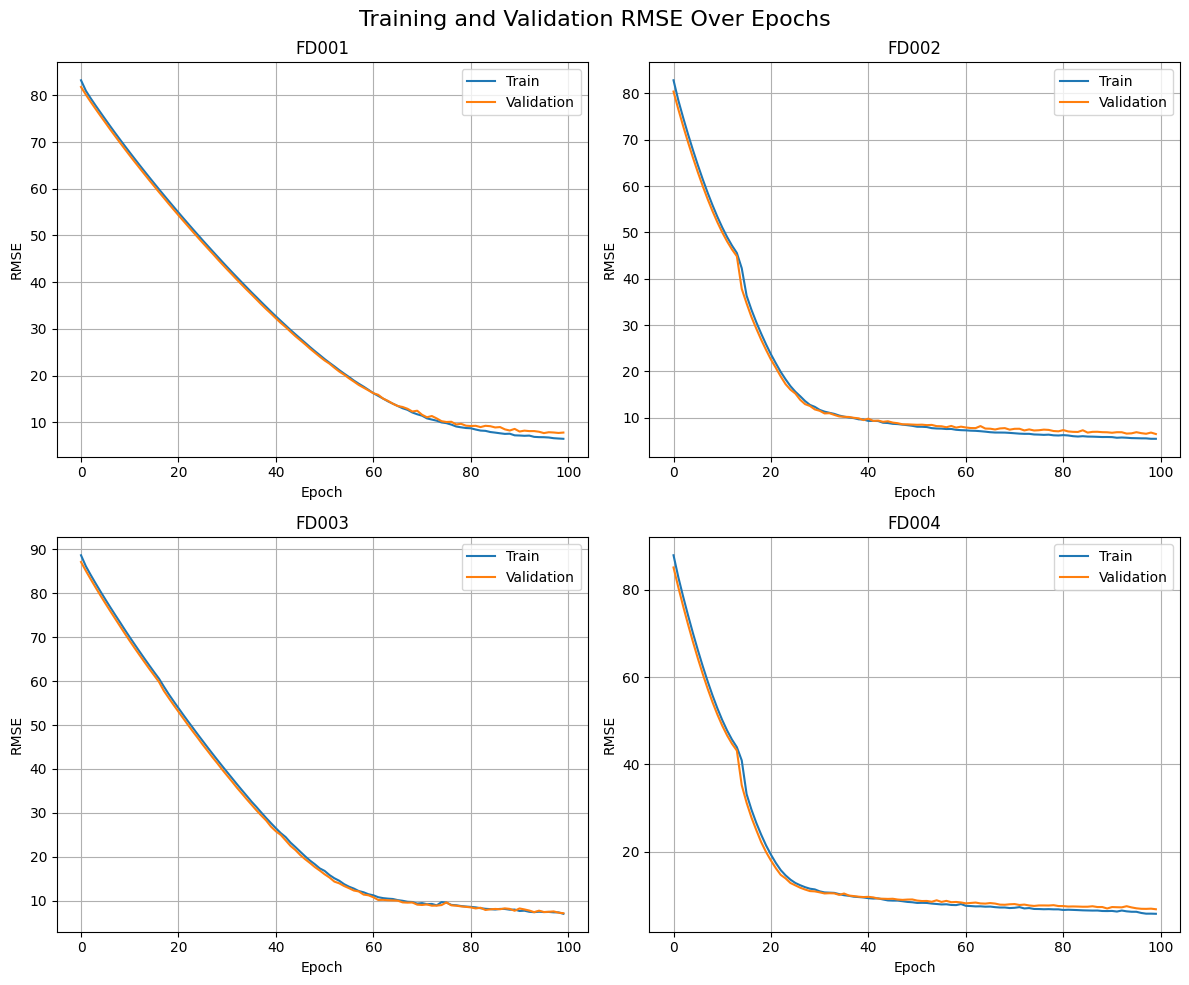

In [6]:
fig, axs = plt.subplots(2, 2, figsize=(12, 10))
axs = axs.ravel()

for i, (name, hist) in enumerate(histories.items()):
    axs[i].plot(hist.history['rmse'], label='Train')
    axs[i].plot(hist.history['val_rmse'], label='Validation')
    axs[i].set_title(name)
    axs[i].set_xlabel('Epoch')
    axs[i].set_ylabel('RMSE')
    axs[i].legend()
    axs[i].grid(True)

fig.suptitle('Training and Validation RMSE Over Epochs', fontsize=16)
plt.tight_layout()
plt.show()


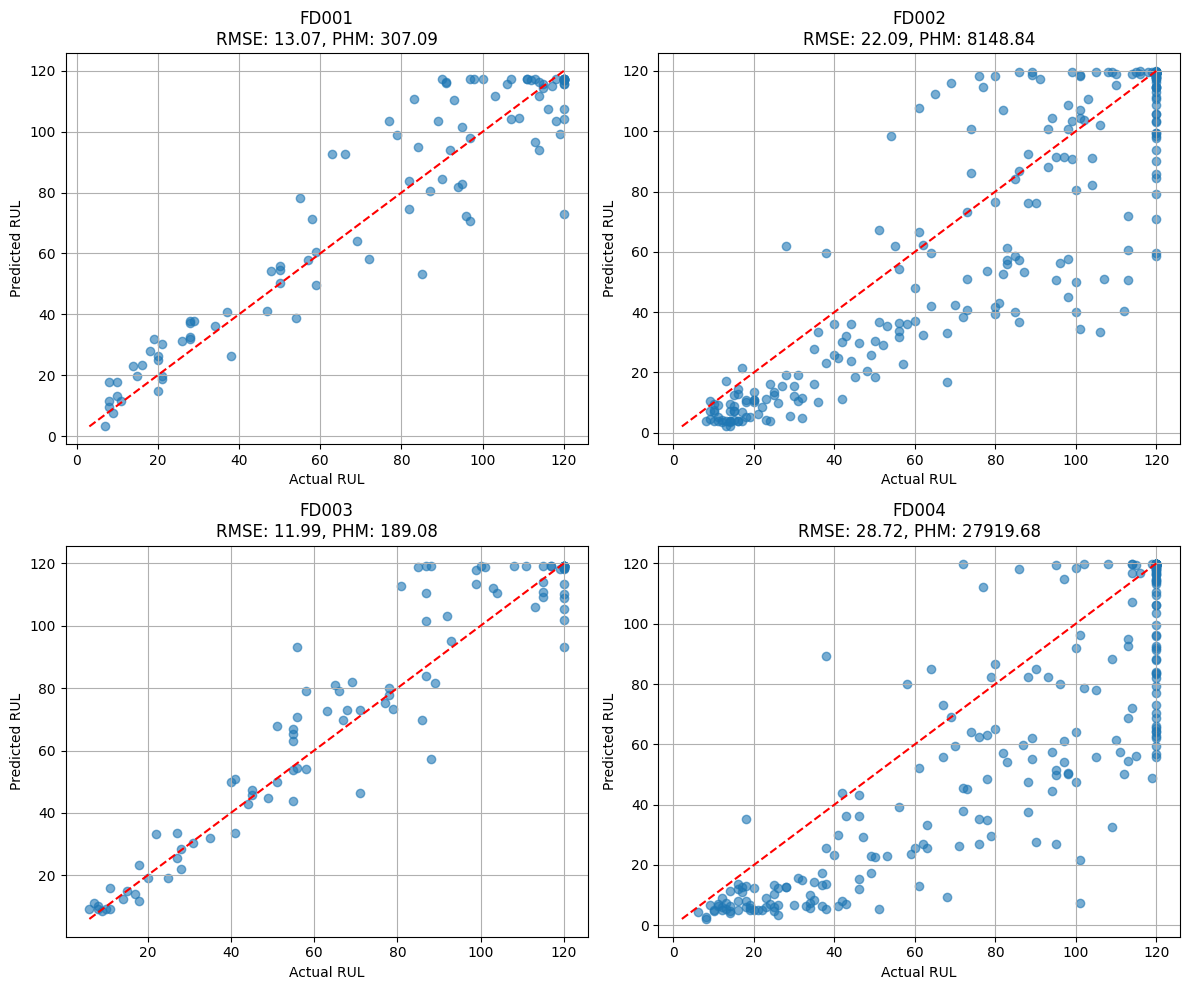

In [7]:
fig, axs = plt.subplots(2, 2, figsize=(12, 10))
axs = axs.ravel()

for i, (name, (y_true, y_pred, rmse_val, phm_val)) in enumerate(all_preds.items()):
    axs[i].scatter(y_true, y_pred, alpha=0.6)
    mn, mx = min(y_true.min(), y_pred.min()), max(y_true.max(), y_pred.max())
    axs[i].plot([mn, mx], [mn, mx], 'r--')
    axs[i].set_title(f'{name}\nRMSE: {rmse_val:.2f}, PHM: {phm_val:.2f}')
    axs[i].set_xlabel('Actual RUL')
    axs[i].set_ylabel('Predicted RUL')
    axs[i].grid(True)

plt.tight_layout()
plt.show()


In [8]:
results_df = pd.DataFrame(results)
display(results_df)

,Dataset,RMSE,Score
0,FD001,13.073396,307.094879
1,FD002,22.091152,8148.842773
2,FD003,11.993175,189.080124
3,FD004,28.720949,27919.679688
